In [346]:
%matplotlib inline
import matplotlib.pyplot as plt
import numpy as np
import tensorflow as tf
import scipy
from scipy.stats import norm
import tensorflow_probability as tfp
import seaborn as sns
import pandas as pd
import corner 
tfd=tfp.distributions

Calculate gravity of polygon

" Computing the gravitaional and magnetic anomalies due to a polygon: Algorithems and Fortran subroutines' Won 1986


In [347]:
def A(x,z,p1,p2):
    numerator = (x[p2]-x[p1])*(x[p1]*z[p2]-x[p2]*z[p1])
    denominator = (x[p2]-x[p1])**2 + (z[p2]-z[p1])**2
    return (numerator/denominator)

def B(x,z,p1,p2):
    return ((z[p1]-z[p2])/(x[p2]-x[p1]))

def theta(x,z, p):
    if x[p] != 0 :
        if(np.arctan(z[p]/x[p]))<0:
            return(np.arctan(z[p]/x[p])+scipy.pi)
        else:
            return(np.arctan(z[p]/x[p]))
    if x[p] == 0 and z[p]!=0 :
        return(scipy.pi/2)

def r(x,z,p):
    return(np.sqrt(x[p]**2+z[p]**2))

def Z(x,z,p1,p2):
    
    if x[p1] == z[p1]==0 or x[p2] == z[p2]==0:
        return(0)
    
    if x[p1] == x[p2]:
        return((x[p1]*np.log(r(x,z,p2)/r(x,z,p1))))
    
    theta1 = theta(x,z, p1)
    theta2 = theta(x,z, p2)
    
    r1 = r(x,z,p1)
    r2 = r(x,z,p2)
    
    #this is only needed when observation location across z
#     if z[p1]*z[p2]<0:
#         if x[p1]*z[p2]==x[p2]*z[p1]:
#             return(0)
#         if x[p1]*z[p2] < x[p2]*z[p1] and z[p2]>=0:
#             theta1 += 2*scipy.pi
#         if x[p1]*z[p2] > x[p2]*z[p1] and z[p1]>=0:
#             theta2 += 2*scipy.pi
    
    _A = A(x,z,p1,p2)
    _B = B(x,z,p1,p2)
    
    Z_result = _A*((theta1-theta2)+_B*np.log(r1/r2))
    return(Z_result)

Gravity at origin is calculated as $\Delta g_{z}=2 G \rho \sum_{i=1}^{n} Z_{i}$
(Won, 1987)

In [348]:
def g(data,loc=(0,0)):
    
    G = 6.67 * 10**(-11) # gravitational constant  m^3 kg ^-1 s^-2
    rho = 1000        # density difference   kg/m^3
    
    _data = data - loc #Calculate any point refer to the origin

    _x = _data[:,0]
    _z = _data[:,1]

    Z_sum = 0
    
    for i in range(_data.shape[0]-1):
        Z_sum += Z(_x,_z,i,i+1)

    Z_sum += Z(_x,_z,-1,0)

    g = 2*G*rho * Z_sum
    
    return(g)

In [349]:
def draw(points,ax = None,R = 100):
    if ax == None:
        f,ax=plt.subplots()
    x = points[:,0]
    z = points[:,1]
    for i in range(points.shape[0]):
        ax.plot(x[i:i+2],z[i:i+2],'r-')
    x_ = np.linspace(-R,R,10)
    ax.plot(x_,np.zeros(np.shape(x_)),lw = 0.5)# draw a reference line, surface
    ax.plot([x[0],x[-1]],[z[0],z[-1]],'r-')
    ax.set_ylim(min(points[:,1])-10,5)
    ax.set_xlim(-R,R)
    
def grav_calculate(points_,x=None, R=70,ax = None,style = None):
    if ax is None:
        f,ax=plt.subplots()
    if x is None:
        x = np.linspace(-R,R,501)
    y = np.zeros(np.shape(x))
    obv = np.vstack((x,y)).T
    gravity = []
    for i in obv:
        gravity.append(-g(points_,i))
    if style is None:
        style = '-'
    ax.plot(x,gravity,style)
    return gravity
    
def plot_true(points,R = None,ax = None):
    if R is None:
        R =max(points[:,0])
    if ax is None:
        f , ax = plt.subplots(2 , sharex = True, figsize = (7,10))
        
    grav_calculate(points, R=max(points[:,0]),ax = ax[0])
    draw(points,ax = ax[1],R=R)
    
    

<b> "note: if z is positive downward and x is positive to the right, then the polygen vertices must be specified clock-wise. " --Won 1987

In [350]:
#define a pseudo boundary condition and corner points
corners=np.array([[-200,-50],# bottom left coner
              [200,-50], 
              [200,-3], # bottom right coner
              [70, -3], # top right coner
              [-70,-3],# top left coner
              [-200,-3]])

In [351]:
corners.shape

(6, 2)

set up the problem

In [352]:
N = 10
points = np.empty((N+6,2))

for i in range(corners.shape[0]-2):
    points[i] = corners[i]
    
points[-2]=corners[-2]
points[-1]=corners[-1]

np.random.seed(11)

x = np.linspace(-70,70,N+2)

y = np.random.uniform(min(corners[:,1]),max(corners[:,1]),N)

In [353]:
for i in range(N):
    points[i+4][1] = y[i]
for i in range(N):
    points[i+4][0] = x[-i-2]

In [354]:
import copy
points_copy = copy.deepcopy(points)

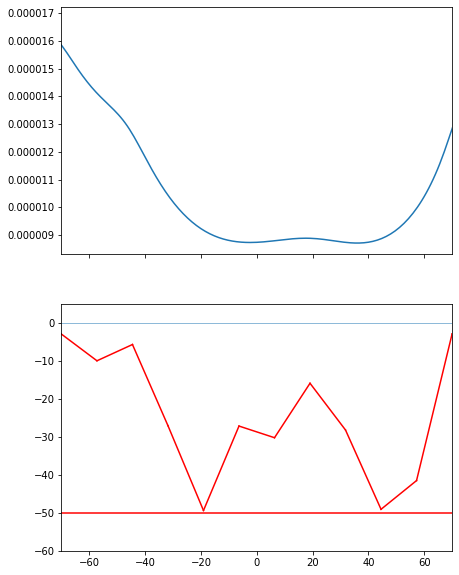

In [355]:
plot_true(points,70)

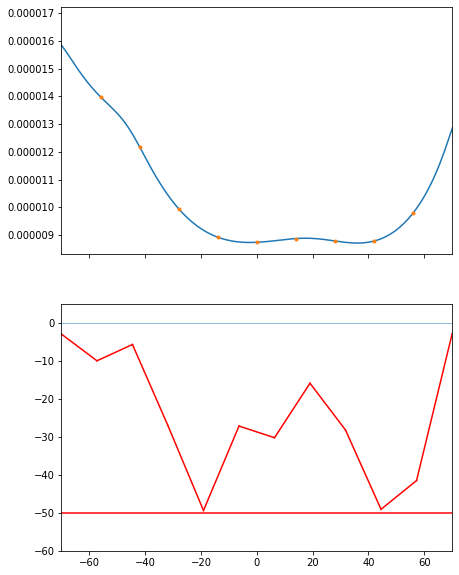

In [356]:
x_obs = np.linspace(-70., 70., 11)
x_obs = x_obs[1:-1]
f,ax = plt.subplots(2,sharex = True,figsize = (7,10))
plot_true(points,70,ax)
obs_data = grav_calculate(points,x=x_obs,ax = ax[0],style='.')

In [403]:
points

array([[-200.        ,  -50.        ],
       [ 200.        ,  -50.        ],
       [ 200.        ,   -3.        ],
       [  70.        ,   -3.        ],
       [  57.27272727,  -41.52732462],
       [  44.54545455,  -49.08466365],
       [  31.81818182,  -28.22872925],
       [  19.09090909,  -15.92810533],
       [   6.36363636,  -30.25043058],
       [  -6.36363636,  -27.18492639],
       [ -19.09090909,  -49.39930171],
       [ -31.81818182,  -27.09353446],
       [ -44.54545455,   -5.73508734],
       [ -57.27272727,  -10.0126308 ],
       [ -70.        ,   -3.        ],
       [-200.        ,   -3.        ]])

In [402]:
points123 = 10*points
points123[:,0]=points123[:,0]+600
points123[:,1] = points123[:,1] + 600
points123

array([[-1400.        ,   100.        ],
       [ 2600.        ,   100.        ],
       [ 2600.        ,   570.        ],
       [ 1300.        ,   570.        ],
       [ 1172.72727273,   184.72675377],
       [ 1045.45454545,   109.1533635 ],
       [  918.18181818,   317.71270745],
       [  790.90909091,   440.71894672],
       [  663.63636364,   297.49569416],
       [  536.36363636,   328.15073614],
       [  409.09090909,   106.00698286],
       [  281.81818182,   329.06465544],
       [  154.54545455,   542.6491266 ],
       [   27.27272727,   499.87369201],
       [ -100.        ,   570.        ],
       [-1400.        ,   570.        ]])

In [357]:
noise = norm(0,0.0000001).rvs(len(obs_data))
grav_obs_withnoise = obs_data+noise

9 observation points,10 parameters

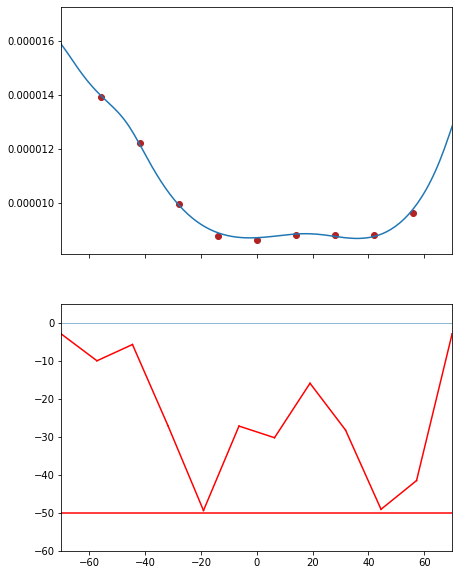

In [358]:
f,ax = plt.subplots(2,sharex = True,figsize = (7,10))
plot_true(points,70,ax)
ax[0].scatter(x_obs,grav_obs_withnoise,color='firebrick')

In [359]:
dtype = tf.float32

In [360]:
obs_data = grav_calculate(points,x=x_obs,ax = ax[0],style='.')

In [361]:
def grav(base,ps):
    
    #base_points:2xN tensor contains x location
    #ps: 1xN vector, elevation variate
    
    for i in range(N):
        base[i+4][1] = ps[i]
        
    x_obv = np.linspace(-70., 70., 11)
    y_obv = np.zeros(np.shape(x_obv))
    obv = np.vstack((x_obv,y_obv)).T
    
    gravity = []
    for i in obv[1:-1]:
        gravity.append(-g(base,i))
        
    return gravity

In [362]:
obs_data

[1.3986746336448605e-05,
 1.2182948871173157e-05,
 9.948058324737362e-06,
 8.921184308260063e-06,
 8.73591959548554e-06,
 8.871654777964887e-06,
 8.784141138333877e-06,
 8.780303233957679e-06,
 9.786056871412718e-06]

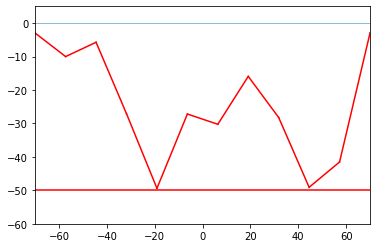

In [363]:
draw(points_copy,R=70)

In [364]:
# mu_prior = [-25,-20,-30,-25,-13,-13,-35,-35,-35,-30]

mu_prior = [-40,-40,-30,-20,-30,-30,-40,-30,-10,-10]
cov_prior = 50.*tf.eye(N)

sig_e = 0.0000005
cov = sig_e**2*tf.eye(np.shape(obs_data)[0])

In [365]:
sig_e

5e-07

\begin{equation}
\mathbf{e}=\mathbf{d}-\mathbf{G} \mathbf{m}
\end{equation}
\begin{equation}
p(\mathbf{d} | \boldsymbol{\theta}, \mathscr{J})=\frac{1}{\left(2 \pi \bar{\sigma}_{\mathbf{e}}^{2}\right)^{N / 2}} \exp \left(-\frac{\mathbf{e}^{\mathrm{T}} \mathbf{e}}{2 \bar{\sigma}_{\mathbf{e}}^{2}}\right)
\end{equation}

In [366]:
d = tf.convert_to_tensor(obs_data,dtype)
d

<tf.Tensor: id=36261018, shape=(9,), dtype=float32, numpy=
array([1.3986746e-05, 1.2182949e-05, 9.9480585e-06, 8.9211844e-06,
       8.7359194e-06, 8.8716552e-06, 8.7841408e-06, 8.7803037e-06,
       9.7860566e-06], dtype=float32)>

In [367]:
def joint_log_prob(D,points_copy,ps):
    """
    D: is the observation data
    ps: is the variable point positions (N elements vector)
    """
    # define random variables prior
    mvn_prior = tfd.MultivariateNormalFullCovariance(
            loc = mu_prior,
            covariance_matrix= cov_prior)
    # define likelihood
    
    Gm_ = grav(points_copy,ps)
    Gm = tf.convert_to_tensor(Gm_,dtype)
    
    mvn_likelihood = tfd.MultivariateNormalFullCovariance(
            loc = Gm,
            covariance_matrix= cov)
    
    # return the posterior probability
    return(mvn_prior.log_prob(ps)
          +mvn_likelihood.log_prob(D))

In [368]:
num_results = 3000
burnin = 5000

initial_chain_state = [
    -10 * tf.ones([N], dtype=tf.float32, name="init_t1"),
]

unnormalized_posterior_log_prob = lambda *args: joint_log_prob(obs_data,points_copy,*args)

samples, kernel_results = tfp.mcmc.sample_chain(
    num_results=num_results,
    current_state=initial_chain_state,
    kernel=tfp.mcmc.RandomWalkMetropolis(
        target_log_prob_fn=unnormalized_posterior_log_prob),
    num_burnin_steps=burnin,
    num_steps_between_results=1,  # Thinning.
    parallel_iterations=1)
samples = tf.stack(samples, axis=-1)
accepted = kernel_results.is_accepted

samples = samples.numpy()
accepted = accepted.numpy()


/Users/zhouji/.local/lib/python3.7/site-packages/tensorflow_probability/python/mcmc/sample.py:335: UserWarning: Tracing all kernel results by default is deprecated. Set the `trace_fn` argument to None (the future default value) or an explicit callback that traces the values you are interested in.
  warnings.warn("Tracing all kernel results by default is deprecated. Set "


In [369]:
accept_index = np.where(accepted==True)
accepted_samples = samples[accept_index]

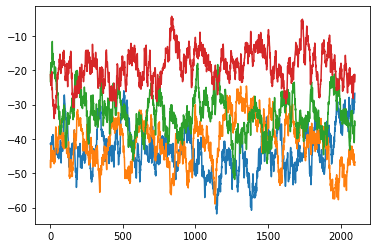

In [370]:
plt.plot(accepted_samples[:,0:4,0])

In [371]:
accepted_samples[:,:,0].shape

(2099, 10)

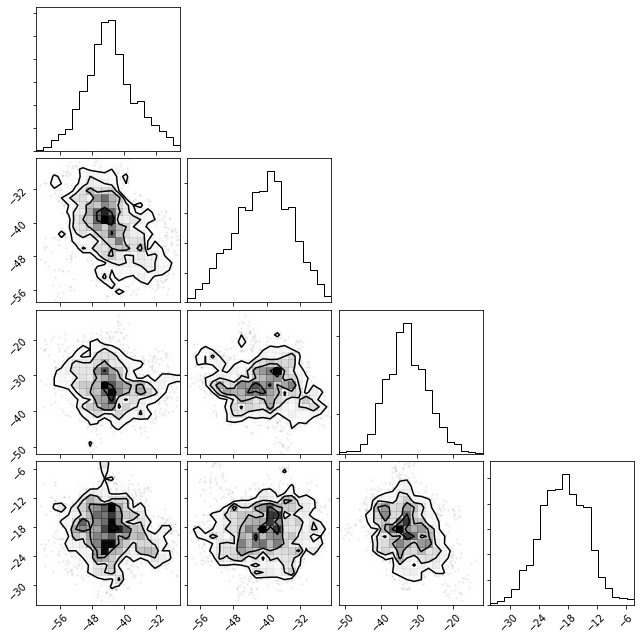

In [372]:
figure = corner.corner(accepted_samples[:,0:4,0])

TO DO:
1.  add a entropy plotting function
2.  compare with prior info and without
3.  Hessian MCMC

In [373]:
def draw_MCMC(base,samples,ax = None,R = 70):
    if ax == None:
        f,ax=plt.subplots()
        
    base_ = copy.deepcopy(base)
    
    x_ = base_[:,0]
    z_ = base_[:,1]
    
    x = base[:,0]
    z = base[:,1]
    
    for i in range(base_.shape[0]):
        ax.plot(x[i:i+2],z[i:i+2],'k-')
    x1 = np.linspace(-R,R,N)
    for ps in samples:
        for j in range(N):
            base_[j+4][1] = ps[j]
        for i in range(3,base_.shape[0]-1):
            ax.plot(base_[:,0][i:i+2],base_[:,1][i:i+2],'r-',alpha = 0.005)
    ax.plot(x1,np.zeros(np.shape(x1)),lw = 0.5)# draw a reference line, surface
    ax.set_ylim(min(base[:,1])-10,5)
    ax.set_xlim(-R,R)

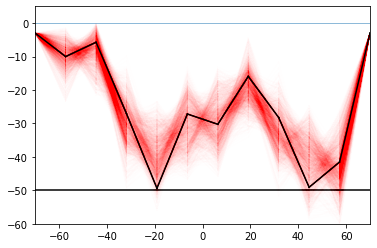

In [374]:
draw_MCMC(points,accepted_samples[:,:,0])
plt.savefig('RMH.png')

Only sample from Prior distribution

In [375]:
def joint_log_prob(D,points_copy,ps):
    """
    D: is the observation data
    ps: is the variable point positions (N elements vector)
    """
    # define random variables prior
    mvn_prior = tfd.MultivariateNormalFullCovariance(
            loc = mu_prior,
            covariance_matrix= cov_prior)
    # define likelihood
    
    Gm_ = grav(points_copy,ps)
    Gm = tf.convert_to_tensor(Gm_,dtype)
    
    mvn_likelihood = tfd.MultivariateNormalFullCovariance(
            loc = Gm,
            covariance_matrix= cov)
    
    # return the posterior probability
    return(mvn_prior.log_prob(ps))

In [376]:
num_results = 3000
burnin = 5000

initial_chain_state = [
    -10 * tf.ones([N], dtype=tf.float32, name="init_t1"),
]

unnormalized_posterior_log_prob = lambda *args: joint_log_prob(obs_data,points_copy,*args)

samples, kernel_results = tfp.mcmc.sample_chain(
    num_results=num_results,
    current_state=initial_chain_state,
    kernel=tfp.mcmc.RandomWalkMetropolis(
        target_log_prob_fn=unnormalized_posterior_log_prob),
    num_burnin_steps=burnin,
    num_steps_between_results=1,  # Thinning.
    parallel_iterations=1)
samples = tf.stack(samples, axis=-1)
accepted = kernel_results.is_accepted

samples = samples.numpy()
accepted = accepted.numpy()

accept_index = np.where(accepted==True)
accepted_samples_prior = samples[accept_index]


/Users/zhouji/.local/lib/python3.7/site-packages/tensorflow_probability/python/mcmc/sample.py:335: UserWarning: Tracing all kernel results by default is deprecated. Set the `trace_fn` argument to None (the future default value) or an explicit callback that traces the values you are interested in.
  warnings.warn("Tracing all kernel results by default is deprecated. Set "


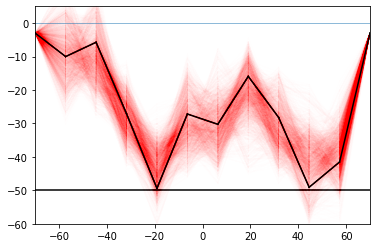

In [377]:
draw_MCMC(points,accepted_samples_prior[:,:,0])
plt.savefig('prior.png')

if without prior info

In [378]:
low_ = -50*tf.ones(N)
high_ = -1*tf.ones(N)

In [379]:
cov

<tf.Tensor: id=36261017, shape=(9, 9), dtype=float32, numpy=
array([[2.5e-13, 0.0e+00, 0.0e+00, 0.0e+00, 0.0e+00, 0.0e+00, 0.0e+00,
        0.0e+00, 0.0e+00],
       [0.0e+00, 2.5e-13, 0.0e+00, 0.0e+00, 0.0e+00, 0.0e+00, 0.0e+00,
        0.0e+00, 0.0e+00],
       [0.0e+00, 0.0e+00, 2.5e-13, 0.0e+00, 0.0e+00, 0.0e+00, 0.0e+00,
        0.0e+00, 0.0e+00],
       [0.0e+00, 0.0e+00, 0.0e+00, 2.5e-13, 0.0e+00, 0.0e+00, 0.0e+00,
        0.0e+00, 0.0e+00],
       [0.0e+00, 0.0e+00, 0.0e+00, 0.0e+00, 2.5e-13, 0.0e+00, 0.0e+00,
        0.0e+00, 0.0e+00],
       [0.0e+00, 0.0e+00, 0.0e+00, 0.0e+00, 0.0e+00, 2.5e-13, 0.0e+00,
        0.0e+00, 0.0e+00],
       [0.0e+00, 0.0e+00, 0.0e+00, 0.0e+00, 0.0e+00, 0.0e+00, 2.5e-13,
        0.0e+00, 0.0e+00],
       [0.0e+00, 0.0e+00, 0.0e+00, 0.0e+00, 0.0e+00, 0.0e+00, 0.0e+00,
        2.5e-13, 0.0e+00],
       [0.0e+00, 0.0e+00, 0.0e+00, 0.0e+00, 0.0e+00, 0.0e+00, 0.0e+00,
        0.0e+00, 2.5e-13]], dtype=float32)>

In [380]:

def joint_log_prob(D,points_,ps):
    """
    D: is the observation data
    ps: is the variable point positions (N elements vector)
    """
    # define random variables prior
    mvn_prior = tfd.Uniform(
            low = low_,
            high = high_)
    # define likelihood
    
    Gm_ = grav(points_,ps)
    Gm = tf.convert_to_tensor(Gm_,dtype)
    
    mvn_likelihood = tfd.MultivariateNormalFullCovariance(
            loc = Gm,
            covariance_matrix= cov)
    
    # return the posterior probability
    return(tf.reduce_sum(mvn_prior.log_prob(ps))
          +mvn_likelihood.log_prob(D))

In [381]:
points

array([[-200.        ,  -50.        ],
       [ 200.        ,  -50.        ],
       [ 200.        ,   -3.        ],
       [  70.        ,   -3.        ],
       [  57.27272727,  -41.52732462],
       [  44.54545455,  -49.08466365],
       [  31.81818182,  -28.22872925],
       [  19.09090909,  -15.92810533],
       [   6.36363636,  -30.25043058],
       [  -6.36363636,  -27.18492639],
       [ -19.09090909,  -49.39930171],
       [ -31.81818182,  -27.09353446],
       [ -44.54545455,   -5.73508734],
       [ -57.27272727,  -10.0126308 ],
       [ -70.        ,   -3.        ],
       [-200.        ,   -3.        ]])

In [382]:
num_results = 5000
burnin = 3000

initial_chain_state = [
    -10 * tf.ones([N], dtype=tf.float32, name="init_t1"),
]

unnormalized_posterior_log_prob = lambda *args: joint_log_prob(obs_data,points_copy,*args)

def gauss_new_state_fn(scale, dtype):
  gauss = tfd.Normal(loc=dtype(0), scale=dtype(scale))
  def _fn(state_parts, seed):
    next_state_parts = []
    seed_stream  = tfp.util.SeedStream(seed, salt='RandomNormal')
    for sp in state_parts:
      next_state_parts.append(sp + gauss.sample(
        sample_shape=sp.shape, seed=seed_stream()))
    return next_state_parts
  return _fn

dtype = np.float32

samples, kernel_results = tfp.mcmc.sample_chain(
    num_results=num_results,
    current_state=initial_chain_state,
    kernel=tfp.mcmc.RandomWalkMetropolis(
        target_log_prob_fn=unnormalized_posterior_log_prob,
        new_state_fn=gauss_new_state_fn(scale=1, dtype=dtype)),
    num_burnin_steps=burnin,
    num_steps_between_results=1,  # Thinning.
    parallel_iterations=1)

samples = tf.stack(samples, axis=-1)
accepted = kernel_results.is_accepted

samples = samples.numpy()
accepted = accepted.numpy()


/Users/zhouji/.local/lib/python3.7/site-packages/tensorflow_probability/python/mcmc/sample.py:335: UserWarning: Tracing all kernel results by default is deprecated. Set the `trace_fn` argument to None (the future default value) or an explicit callback that traces the values you are interested in.
  warnings.warn("Tracing all kernel results by default is deprecated. Set "


In [383]:
accept_index = np.where(accepted==True)
accepted_samples = samples[accept_index]

In [384]:
accepted_samples

array([[[-25.60647  ],
        [-33.369087 ],
        [-39.0522   ],
        ...,
        [-31.462507 ],
        [ -9.856666 ],
        [ -8.033625 ]],

       [[-26.082783 ],
        [-36.109463 ],
        [-39.264748 ],
        ...,
        [-33.794376 ],
        [ -8.268208 ],
        [ -8.353395 ]],

       [[-26.748867 ],
        [-37.201443 ],
        [-39.560966 ],
        ...,
        [-33.423183 ],
        [ -8.285268 ],
        [ -6.866248 ]],

       ...,

       [[-48.1109   ],
        [-17.981655 ],
        [-49.06675  ],
        ...,
        [-26.660486 ],
        [ -4.2960577],
        [-12.623925 ]],

       [[-48.823853 ],
        [-18.366308 ],
        [-49.977367 ],
        ...,
        [-26.471363 ],
        [ -3.3079271],
        [-12.33481  ]],

       [[-48.605957 ],
        [-19.983315 ],
        [-48.87405  ],
        ...,
        [-26.318808 ],
        [ -3.2487144],
        [-10.812549 ]]], dtype=float32)

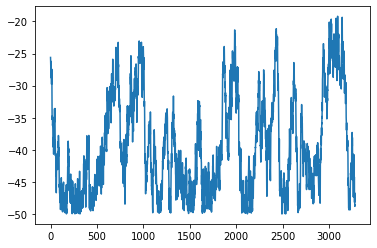

In [385]:
plt.plot(accepted_samples[:,0:1,0])

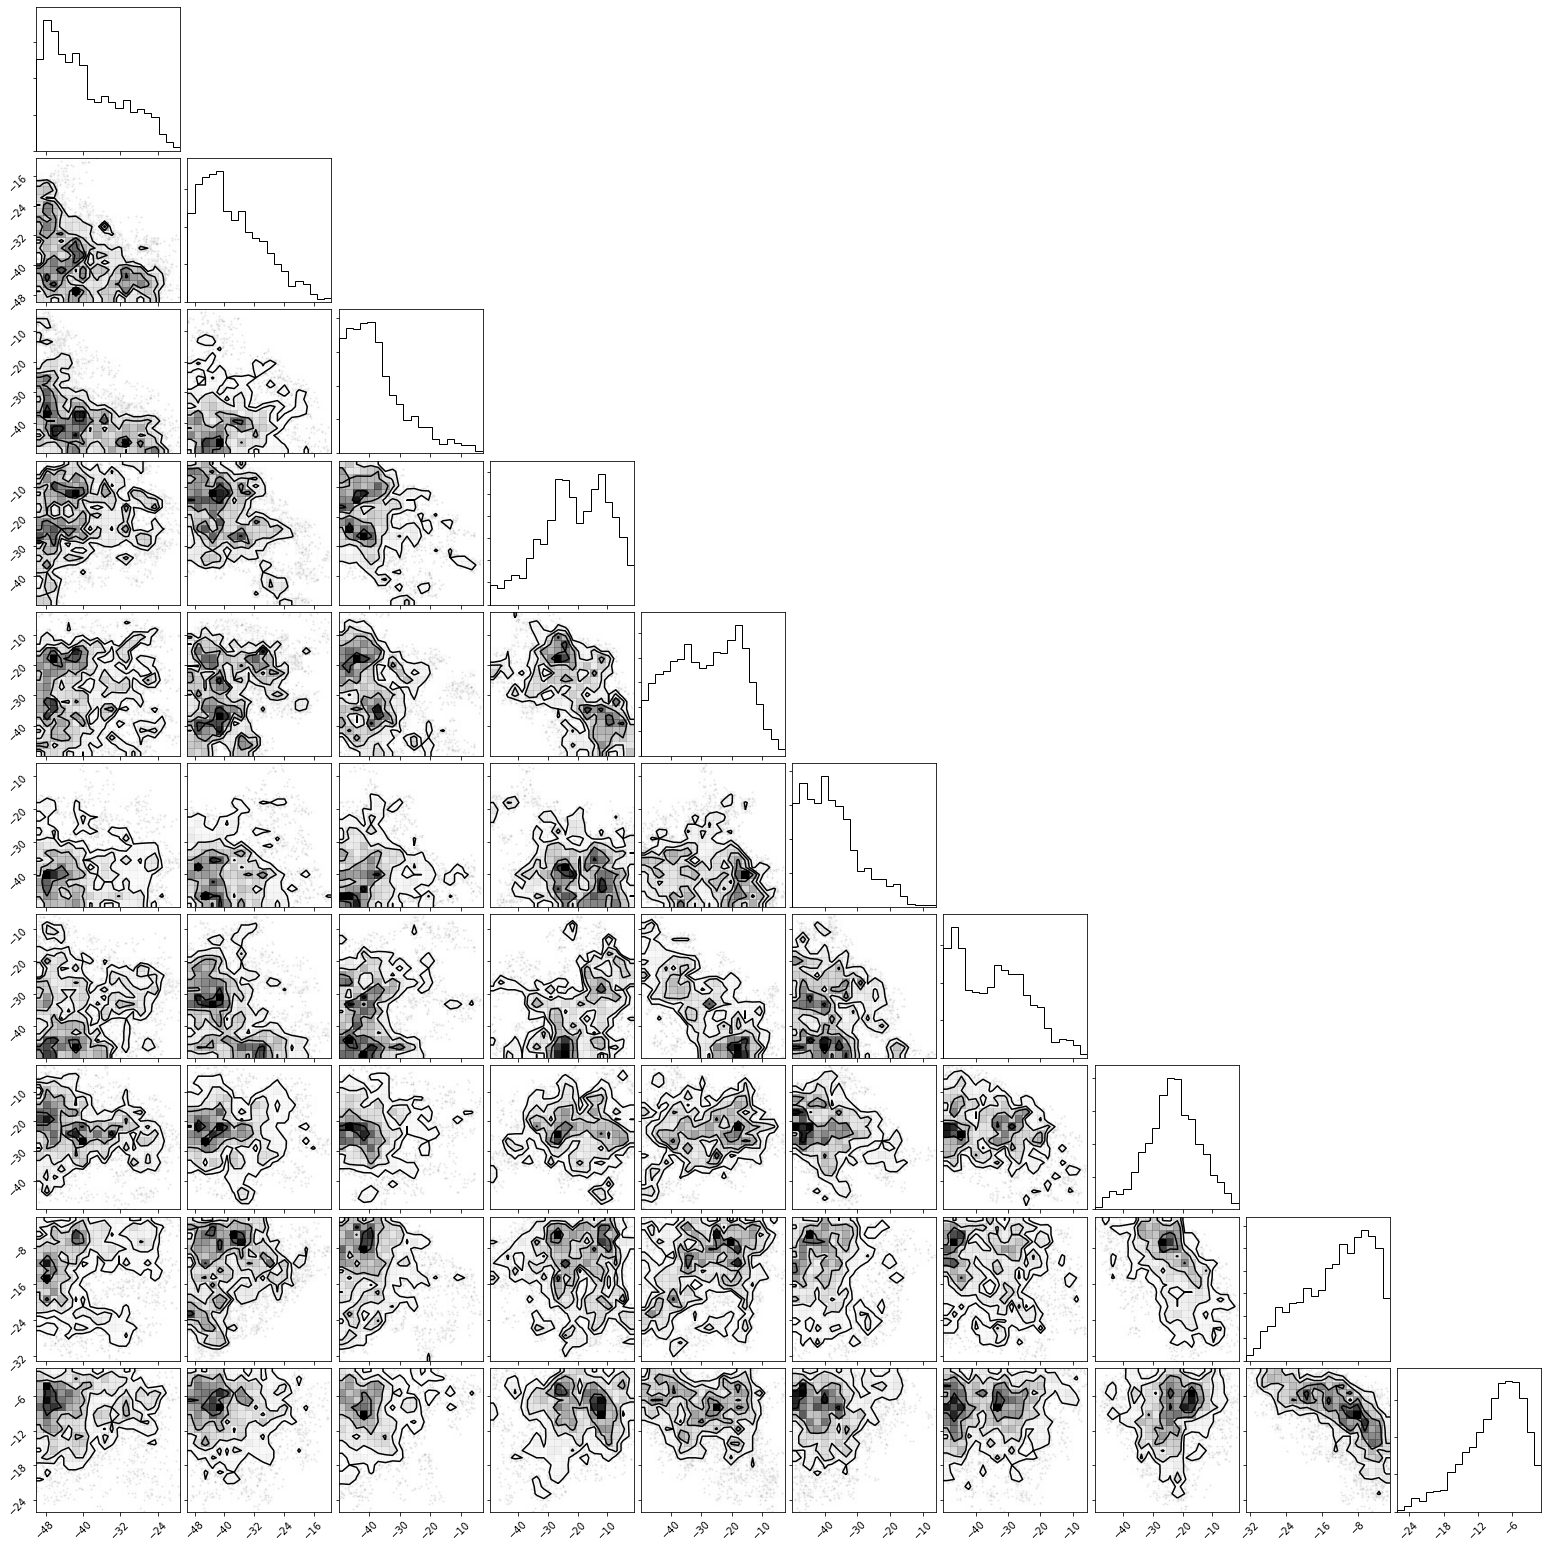

In [386]:
figure = corner.corner(accepted_samples[:,:,0])

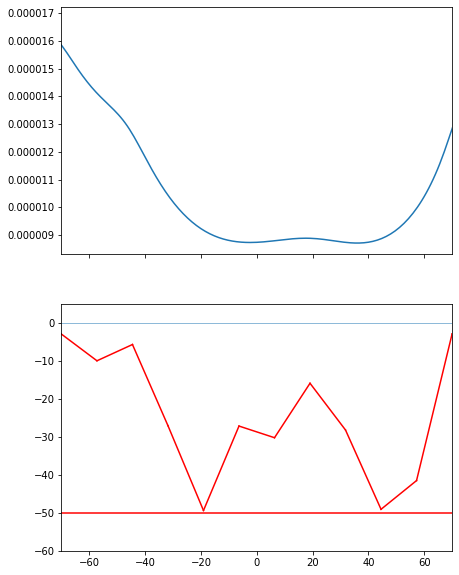

In [387]:
plot_true(points,70)

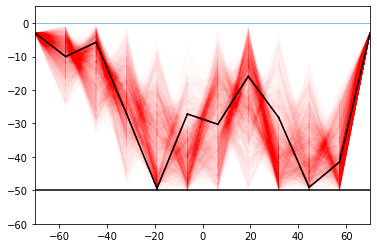

In [388]:
draw_MCMC(points,accepted_samples[:,:,0],R=70)
plt.savefig('likelihood.png')

In [389]:
def joint_log_prob(D,points_copy,ps):

    # define likelihood
    
    Gm_ = grav(points_copy,ps)
    print(Gm_)
    Gm = tf.convert_to_tensor(Gm_,dtype)
    
    mvn_likelihood = tfd.MultivariateNormalFullCovariance(
            loc = Gm,
            covariance_matrix= cov)
    
    # return the posterior probability
    return(mvn_likelihood.log_prob(D))

In [390]:
ps = [-9,-45]
joint_log_prob(obs_data,points_copy,ps)

# Gm_1 = np.array(grav(points_copy,ps))
# obs_data = np.array(obs_data)
# e =np.reshape((obs_data-Gm_1),[9,1])
# et = np.transpose(e)
# cov_1 = np.linalg.inv(cov)

# np.exp(-np.matmul(np.matmul(et,cov_1),e))

IndexError: list index out of range

In [ ]:
ps = [-25,-20]
joint_log_prob(obs_data,points_copy,ps)
# Gm_2 = np.array(grav(points_copy,ps))
# obs_data = np.array(obs_data)
# e =np.reshape((obs_data-Gm_2),[9,1])
# et = np.transpose(e)
# cov_1 = np.linalg.inv(cov)
# np.exp(-np.matmul(np.matmul(et,cov_1),e))


In [ ]:
obs_data

In [ ]:
points

In [ ]:
cov

In [ ]:
def multivariate_normal(x, d, mean, covariance):
    """pdf of the multivariate normal distribution."""
    x_m = x - mean
    return (1. / (np.sqrt((2 * np.pi)**d * np.linalg.det(covariance))) * 
            (np.exp(-(np.linalg.solve(covariance, x_m).T.dot(x_m)) / 2)))

In [ ]:
multivariate_normal(obs_data, 9, Gm_1, cov)

MAP

In [ ]:
## Block out in case run by accident, takes too long to run 28 min
ps = tf.constant([-1., -1.])
for i in range(10):
    with tf.GradientTape() as t:  
        t.watch(ps)
        loss = tf.negative(joint_log_prob(obs_data,points_copy,ps))
        dlossdmu = t.gradient(loss,ps)
        print(ps.numpy(),dlossdmu.numpy())
        ps = ps - 0.00001*dlossdmu